# Imports

In [214]:
import numpy as np
import sympy as sp
import matplotlib.pyplot as plt
plt.rcParams.update({'font.size': 12, 
                     'font.family': 'serif', 
                     'figure.figsize': (10, 6), 
                     'mathtext.fontset': 'cm',
                     'axes.prop_cycle': plt.cycler(color=["#3d0dce", "#ff1e1e", "#61ffa6", "#86db0f", "#f711ff", "#64B5CD"])
                 })
np.set_printoptions(precision=3, sign=' ')
tensor_prod = np.kron

import qiskit as qk
from qiskit import QuantumCircuit
from qiskit_aer import Aer, AerSimulator
from qiskit.visualization import plot_histogram

# a)

## Functions

In [215]:
def qubits():
    '''
    Creates the qubits |0⟩ and |1⟩.
    
    Returns
    -------
        q0: np.ndarray
            |0⟩ = [1, 0]
        q1: np.ndarray
            |1⟩ = [0, 1]
    '''
    q0 = np.array([1, 0])
    q1 = np.array([0, 1])
    return q0, q1

def pauli():
    '''
    Creates the Pauli matrices σ_x, σ_y, and σ_z.
    
    Returns
    -------
        σ_x: np.ndarray
            Pauli X
        σ_y: np.ndarray
            Pauli Y
        σ_z: np.ndarray
            Pauli Z
    '''
    σ_x = np.array([[0, 1], [1, 0]]) # Pauli X
    σ_y = np.array([[0, -1j], [1j, 0]]) # Pauli Y
    σ_z = np.array([[1, 0], [0, -1]]) # Pauli Z
    return σ_x, σ_y, σ_z

def hadamard():
    '''
    Creates the Hadamard gate.
    
    Returns
    -------
        H: np.ndarray
            Hadamard gate
    '''
    H = 1/np.sqrt(2) * np.array([[1, 1], [1, -1]]) # Hadamard gate
    return H

def phase():
    '''
    Creates the phase gate.

    Returns
    -------
        S: np.ndarray
            Phase gate
    '''
    S = np.array([[1, 0], [0, 1j]]) # Phase gate
    return S

def cnot():
    '''
    Creates the CNOT gate.
    
    Returns
    -------
        CNOT: np.ndarray
            CNOT gate
    '''
    CNOT = np.array([[1, 0, 0, 0], [0, 1, 0, 0], [0, 0, 0, 1], [0, 0, 1, 0]]) # CNOT gate
    return CNOT

def create_bell_states():
    '''
    Creates the Bell states |Φ⁺⟩, |Φ⁻⟩, |Ψ^+⟩, and |Ψ⁻⟩.
    
    Returns
    -------
        Φ_00: np.ndarray
            |Φ⁺⟩ = (|00⟩ + |11⟩)/√2
        Φ_10: np.ndarray
            |Φ⁻⟩ = (|00⟩ - |11⟩)/√2
        Ψ_01: np.ndarray
            |Ψ⁺⟩ = (|01⟩ + |10⟩)/√2
        Ψ_11: np.ndarray
            |Ψ⁻⟩ = (|01⟩ - |10⟩)/√2
    '''
    q0, q1 = qubits()

    H = hadamard()
    CNOT = cnot()

    q0_H = H @ q0
    q1_H = H @ q1

    Φ_00 = CNOT @ tensor_prod(q0_H, q0) # |Φ⁺⟩ = (|00⟩ + |11⟩)/√2
    Φ_10 = CNOT @ tensor_prod(q1_H, q0) # |Φ⁻⟩ = (|00⟩ - |11⟩)/√2
    Ψ_01 = CNOT @ tensor_prod(q0_H, q1) # |Ψ⁺⟩ = (|01⟩ + |10⟩)/√2
    Ψ_11 = CNOT @ tensor_prod(q1_H, q1) # |Ψ⁻⟩ = (|01⟩ - |10⟩)/√2
    
    return Φ_00, Φ_10, Ψ_01, Ψ_11

def create_system_vectors(n_qubits: int):
    """
    Create the system vectors for a given number of qubits.
    
    Parameters
    ----------
    n_qubits : int
        The number of qubits in the system.
        
    Returns
    -------
    system_vectors : list[np.ndarray]
        A list of system vectors, where each vector represents a possible state of the qubits.
    """
    
    q0, q1 = qubits()
    system_vectors = []
    for i in range(2**n_qubits):
        binary_str = f'{i:0{n_qubits}b}'
        state = np.array([1])
        for bit in binary_str:
            state = tensor_prod(state, q0 if bit == '0' else q1)
        system_vectors.append(state)
        
    return system_vectors
    
        

def measure_qubit(qubit: int, bell_state: np.ndarray):
    '''
    Makes a measurement on a specified cubit in a Bell state
    
    Parameters
    ----------
        qubit: int
            Which cubit to measure. In a two-qubit state one could pass either 0 or 1
        bell_state: np.ndarray
            The state to measure
        
    Returns
    -------
        state: int
            What state the qubit is in. Either 0 or 1
    '''
    n = len(bell_state)
    n_qubits = int(np.log2(n))
    
    measurement_probabilities = {'0': 0, '1': 0}
    for i in range(n):
        binary_str = f'{i:0{n_qubits}b}'[qubit]
        prob = bell_state[i]
        measurement_probabilities[binary_str] += np.abs(prob)**2
        
    # Weighted random choice depending on the state
    result = np.random.choice([0, 1], p=[*measurement_probabilities.values()])

    return result

def measure_all_qubits(bell_state: np.ndarray):
    '''
    Makes a measurement on all qubits in a Bell state

    Parameters
    ----------
        bell_state: np.ndarray
            The state to measure

    Returns
    -------
        state: str
            What state the qubits are in. For a two-qubit system, this would be either '00', '01', '10', or '11'
    '''
    
    n = len(bell_state)
    n_qubits = int(np.log2(n))
    
    measurement_probabilities = {binary_str: 0 for binary_str in [f'{i:0{n_qubits}b}' for i in range(n)]}
    for i, bin_str in enumerate(measurement_probabilities.keys()):
        prob = bell_state[i]
        measurement_probabilities[bin_str] += np.abs(prob)**2
        
    # Weighted random choice depending on the state
    result = np.random.choice([*measurement_probabilities.keys()], p=[*measurement_probabilities.values()])
    return result

### Playing with Qubits
- The following explores how the qubit states can be combined to form composite states. 
- I also explore how their connection to the bit string representation of the state. 
- There seems to be a natural connection between the bit string representation and the order of the qubits in the tensor product.

In [216]:
# Checking the states being as expected and their corresponding binary representation
v1, v2, v3, v4 = create_system_vectors(2)

n = 4
bin_strs = [f'{i:0{int(np.log2(n))}b}' for i in range(n)]

q0, q1 = qubits()
print(tensor_prod(q0, q0), v1, bin_strs[0])
print(tensor_prod(q0, q1), v2, bin_strs[1])
print(tensor_prod(q1, q0), v3, bin_strs[2])
print(tensor_prod(q1, q1), v4, bin_strs[3])

[1 0 0 0] [1 0 0 0] 00
[0 1 0 0] [0 1 0 0] 01
[0 0 1 0] [0 0 1 0] 10
[0 0 0 1] [0 0 0 1] 11


In [217]:
# Checking the states being as expected
v1, v2, v3, v4, v5, v6, v7, v8 = create_system_vectors(3)

n = 8
bin_strs = [f'{i:0{int(np.log2(n))}b}' for i in range(n)]

q0, q1 = qubits()
print(tensor_prod(tensor_prod(q0, q0), q0), v1, bin_strs[0])
print(tensor_prod(tensor_prod(q0, q0), q1), v2, bin_strs[1])
print(tensor_prod(tensor_prod(q0, q1), q0), v3, bin_strs[2])
print(tensor_prod(tensor_prod(q0, q1), q1), v4, bin_strs[3])
print(tensor_prod(tensor_prod(q1, q0), q0), v5, bin_strs[4])
print(tensor_prod(tensor_prod(q1, q0), q1), v6, bin_strs[5])
print(tensor_prod(tensor_prod(q1, q1), q0), v7, bin_strs[6])
print(tensor_prod(tensor_prod(q1, q1), q1), v8, bin_strs[7])

[1 0 0 0 0 0 0 0] [1 0 0 0 0 0 0 0] 000
[0 1 0 0 0 0 0 0] [0 1 0 0 0 0 0 0] 001
[0 0 1 0 0 0 0 0] [0 0 1 0 0 0 0 0] 010
[0 0 0 1 0 0 0 0] [0 0 0 1 0 0 0 0] 011
[0 0 0 0 1 0 0 0] [0 0 0 0 1 0 0 0] 100
[0 0 0 0 0 1 0 0] [0 0 0 0 0 1 0 0] 101
[0 0 0 0 0 0 1 0] [0 0 0 0 0 0 1 0] 110
[0 0 0 0 0 0 0 1] [0 0 0 0 0 0 0 1] 111


## Exploring Pauli Matrices

In [218]:

q0, q1 = qubits()
σ_x, σ_y, σ_z = pauli()

q0_x = σ_x @ q0
q0_y = σ_y @ q0
q0_z = σ_z @ q0

q1_x = σ_x @ q1
q1_y = σ_y @ q1
q1_z = σ_z @ q1

print(f'σ_x|0⟩ = {q0_x}')
print(f'σ_y|0⟩ = {q0_y}')
print(f'σ_z|0⟩ = {q0_z}')
print()
print(f'σ_x|1⟩ = {q1_x}')
print(f'σ_y|1⟩ = {q1_y}')
print(f'σ_z|1⟩ = {q1_z}')

σ_x|0⟩ = [0 1]
σ_y|0⟩ = [ 0.+0.j  0.+1.j]
σ_z|0⟩ = [1 0]

σ_x|1⟩ = [1 0]
σ_y|1⟩ = [ 0.-1.j  0.+0.j]
σ_z|1⟩ = [ 0 -1]


## Exploring Gates

In [219]:
H = hadamard()
S = phase()

q0_H = H @ q0
q0_S = S @ q0

q1_H = H @ q1
q1_S = S @ q1

print(f'H|0⟩ = {q0_H}')
print(f'S|0⟩ = {q0_S}')
print()
print(f'H|1⟩ = {q1_H}')
print(f'S|1⟩ = {q1_S}')

H|0⟩ = [ 0.707  0.707]
S|0⟩ = [ 1.+0.j  0.+0.j]

H|1⟩ = [ 0.707 -0.707]
S|1⟩ = [ 0.+0.j  0.+1.j]


## Bell States
Example of a Bell State and how to create it using a circuit. In this case, the Bell State $\ket{Φ^{+}}$ is created using a Hadamard gate and a CNOT gate: 
$$
\ket{Φ^{+}} =  \frac{1}{\sqrt{2}}\Big(|00\rangle + |11\rangle\Big)
$$ 

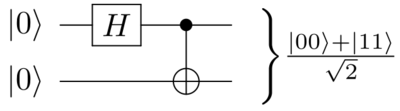](attachment:image.png)

In [220]:
Φ_00, Φ_10, Ψ_01, Ψ_11 = create_bell_states()

print(f'|Φ⁺⟩ = {Φ_00}')
print(f'|Φ⁺⟩ = {Φ_10}')
print(f'|Ψ⁺⟩ = {Ψ_01}')
print(f'|Ψ⁺⟩ = {Ψ_11}')

|Φ⁺⟩ = [ 0.707  0.     0.     0.707]
|Φ⁺⟩ = [ 0.707  0.     0.    -0.707]
|Ψ⁺⟩ = [ 0.     0.707  0.707  0.   ]
|Ψ⁺⟩ = [ 0.     0.707 -0.707  0.   ]


### Alternative Solution

In [221]:
q_00, q_01, q_10, q_11 = create_system_vectors(2)

Φ_00 = 1/np.sqrt(2) * (q_00 + q_11)
Φ_10 = 1/np.sqrt(2) * (q_00 - q_11)
Ψ_01 = 1/np.sqrt(2) * (q_01 + q_10)
Ψ_11 = 1/np.sqrt(2) * (q_01 - q_10)

print(f'|Φ⁺⟩ = {Φ_00}')
print(f'|Φ⁻⟩ = {Φ_10}')
print(f'|Ψ⁺⟩ = {Ψ_01}')
print(f'|Ψ⁻⟩ = {Ψ_11}')

|Φ⁺⟩ = [ 0.707  0.     0.     0.707]
|Φ⁻⟩ = [ 0.707  0.     0.    -0.707]
|Ψ⁺⟩ = [ 0.     0.707  0.707  0.   ]
|Ψ⁻⟩ = [ 0.     0.707 -0.707  0.   ]


In [222]:
H = hadamard()
CNOT = cnot()
I_2 = np.eye(2)

# Applying the Hadamard and CNOT gate to the first Bell state
Φ_00_H = tensor_prod(H, I_2) @ Φ_00
Φ_00_H_CNOT = CNOT @ Φ_00_H

print(f'|Φ⁺⟩ =             {Φ_00}')
print(f'(H ⊗ I)|Φ⁺⟩ =     {Φ_00_H}')
print(f'CNOT(H ⊗ I)|Φ⁺⟩ = {Φ_00_H_CNOT}')

|Φ⁺⟩ =             [ 0.707  0.     0.     0.707]
(H ⊗ I)|Φ⁺⟩ =     [ 0.5  0.5  0.5 -0.5]
CNOT(H ⊗ I)|Φ⁺⟩ = [ 0.5  0.5 -0.5  0.5]


### Testing by Measuring Bell States

In [223]:
# Making a measurment
q1_results = {0: 0, 1: 0}
q2_results = {0: 0, 1: 0}
n = 10_000
for i in range(n):
    q1_res = measure_qubit(0, Φ_00)
    q1_results[q1_res] += 1
    
    q2_res = measure_qubit(1, Φ_00)
    q2_results[q2_res] += 1

Odds of measuring qubit 0 as 0:,  50.20%
Odds of measuring qubit 0 as 1:,  49.80%


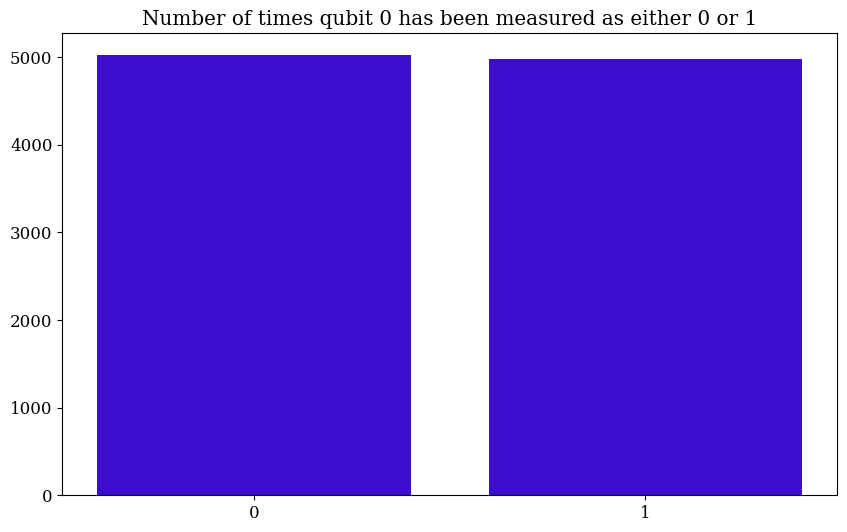

In [224]:
print(f'Odds of measuring qubit 0 as 0:, {q1_results[0]/n: .2%}')
print(f'Odds of measuring qubit 0 as 1:, {q1_results[1]/n: .2%}')

plt.bar(q1_results.keys(), q1_results.values())
plt.xticks([0, 1])
plt.title("Number of times qubit 0 has been measured as either 0 or 1")
plt.show()

Odds of measuring qubit 0 as 0:,  49.95%
Odds of measuring qubit 0 as 1:,  50.05%


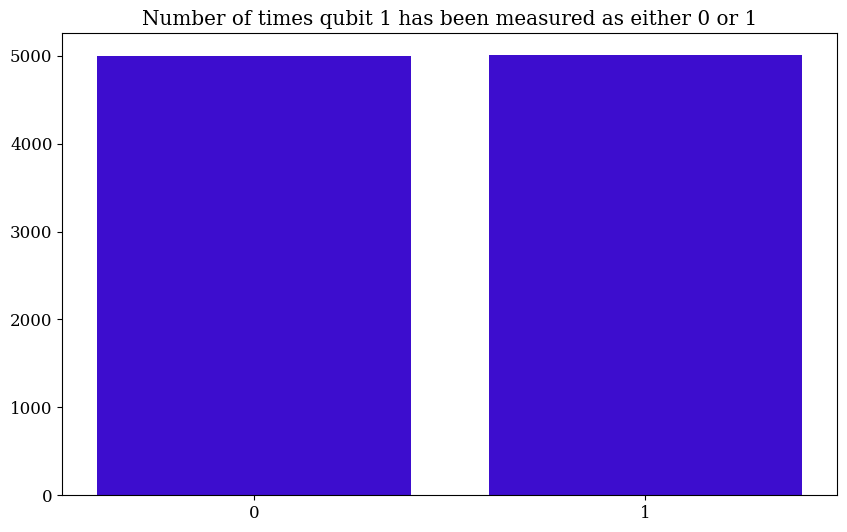

In [225]:
print(f'Odds of measuring qubit 0 as 0:, {q2_results[0]/n: .2%}')
print(f'Odds of measuring qubit 0 as 1:, {q2_results[1]/n: .2%}')

plt.bar(q2_results.keys(), q2_results.values())
plt.xticks([0, 1])
plt.title("Number of times qubit 1 has been measured as either 0 or 1")
plt.show()

## Circuit and Measurements in Qiskit

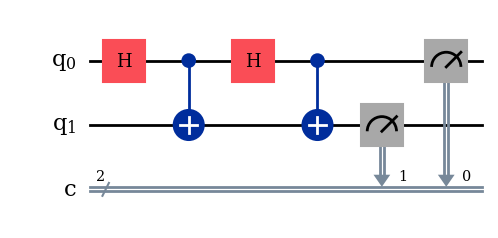

In [226]:
qc = QuantumCircuit(2, 2)
qc.h(0)
qc.cx(0, 1)
qc.h(0)
qc.cx(0, 1)

# Measureing the qubits
qc.measure(1, 1)
qc.measure(0, 0)
qc.draw('mpl')

CNOT (H|Φ⁺⟩) (Qiskit):
----------------------
Odds of measuring both qubits as 0:                24.30%
Odds of measuring qubit 0 as 0, and qubit 1 as 1:  24.86%
Odds of measuring qubit 0 as 1, and qubit 1 as 0:  24.86%
Odds of measuring both qubits as 1                 25.84%

CNOT (H|Φ⁺⟩) (Python):
----------------------
Odds of measuring both qubits as 0:                24.73%
Odds of measuring qubit 0 as 0, and qubit 1 as 1:  25.31%
Odds of measuring qubit 0 as 1, and qubit 1 as 0:  25.10%
Odds of measuring both qubits as 1:                24.87%


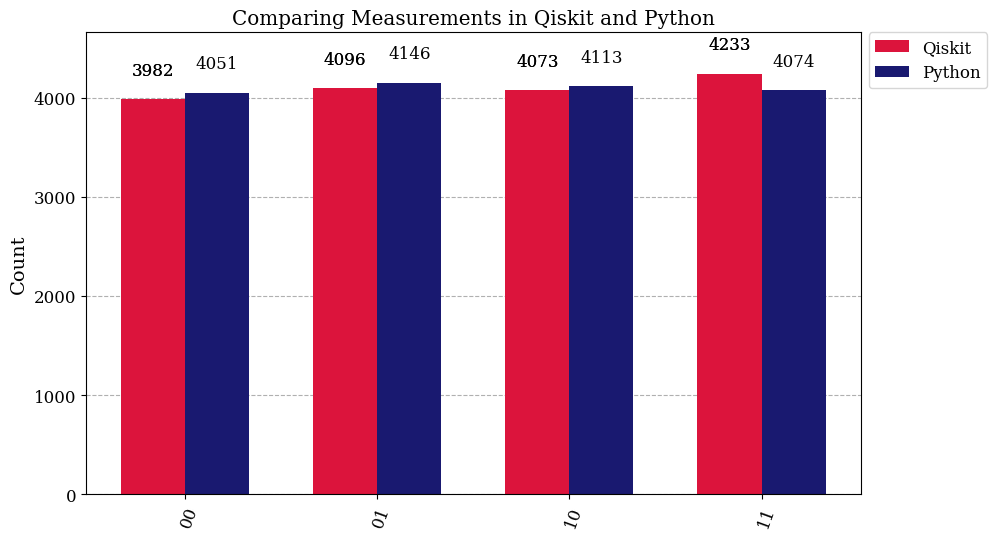

In [227]:
simulator = AerSimulator()
n = 2**14
results_qk = simulator.run(qc, shots=n).result().get_counts(qc)
results_qk = dict(sorted(results_qk.items(), key=lambda x: x[0])) # Sort the results by bit string key
q00, q01, q10, q11 = results_qk.values()

print('CNOT (H|Φ⁺⟩) (Qiskit):')
print('----------------------')
print(f'Odds of measuring both qubits as 0:               {q00/n: .2%}')
print(f'Odds of measuring qubit 0 as 0, and qubit 1 as 1: {q10/n: .2%}')
print(f'Odds of measuring qubit 0 as 1, and qubit 1 as 0: {q10/n: .2%}')
print(f'Odds of measuring both qubits as 1                {q11/n: .2%}')

# Comparing with python implementation
H = hadamard()
CNOT = cnot()
Φ_00 = create_bell_states()[0]

state = CNOT @ tensor_prod(H, I_2) @ Φ_00

results_py = {f'{i:02b}': 0 for i in range(4)}
for i in range(n):
    res = measure_all_qubits(state)
    results_py[res] += 1

q00, q01, q10, q11 = results_py.values()

print()
print('CNOT (H|Φ⁺⟩) (Python):')
print('----------------------')
print(f'Odds of measuring both qubits as 0:               {q00/n: .2%}')
print(f'Odds of measuring qubit 0 as 0, and qubit 1 as 1: {q01/n: .2%}')
print(f'Odds of measuring qubit 0 as 1, and qubit 1 as 0: {q10/n: .2%}')
print(f'Odds of measuring both qubits as 1:               {q11/n: .2%}')
plot_histogram([results_qk, results_py], title="Comparing Measurements in Qiskit and Python", 
                                         legend=['Qiskit', 'Python'], 
                                         color=['crimson', 'midnightblue'] )

## Conclusion
- As we can see, the qubit states can be combined to form composite states using the tensor product of $\ket{0}$ and $\ket{1}$.
- We looked at the bell state $\ket{Φ^{+}}$, in which both qubits are either in the state $\ket{0}$, represented by ($\ket{00}$), or $\ket{1}$ represented by ($\ket{11}$). 
- Applying a Hadamard and CNOT gate to $\ket{Φ^{+}}$, we get the expected results of approximately a 25% chance of measuring either $\ket{00}$, $\ket{01}$, $\ket{10}$  or $\ket{11}$.

# b)

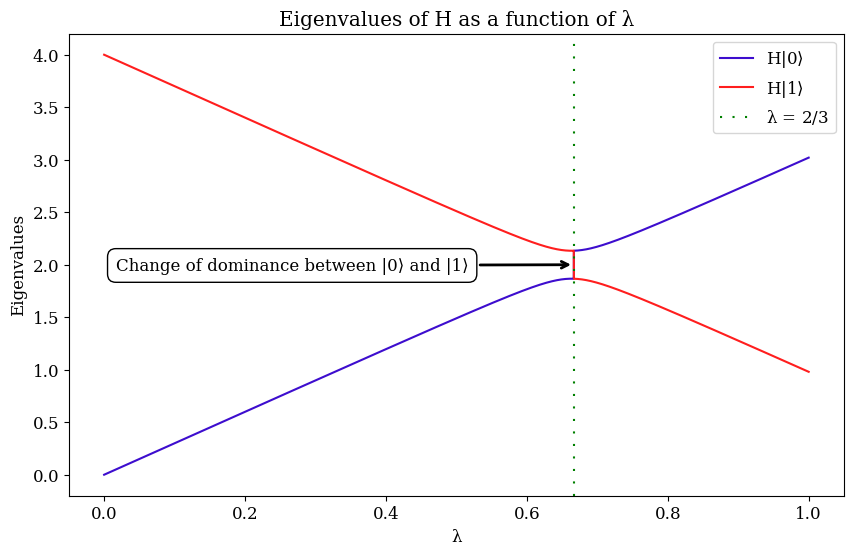

In [228]:
E1 = 0
E2 = 4
E = (E1 + E2) / 2
Ω = (E1 - E2) / 2
σ_x, σ_y, σ_z = pauli()
I_2 = np.eye(2)
H0 = E*I_2 + Ω*σ_z

V11 = 3 
V22 = -V11 
V12 = V21 = 0.2
c = (V11 + V22) / 2
ω_z = (V11 - V22) / 2
ω_x = V12
HI = c*I_2 + ω_z*σ_z + ω_x*σ_x

n = 10001
lambdas = np.linspace(0, 1, n)
eigenvalues = []

for λ in lambdas:
    H = H0 + λ*HI
    eigenvalues.append(np.linalg.eigvals(H))


plt.plot(lambdas, eigenvalues)

x = 2/3
y = (eigenvalues[int(2/3*n)][0] + eigenvalues[int(2/3*n)][1]) / 2
plt.annotate(text=r"Change of dominance between |0⟩ and |1⟩", 
          xy=(x, y), 
          xytext=(x-.65, y-.05),
          arrowprops=dict(arrowstyle='->', lw=2), 
          bbox=dict(facecolor='white',
          edgecolor='black',
          boxstyle='round,pad=0.5')), 
plt.xlabel('λ')
plt.axvline(x=2/3, color='green', linestyle=(0, (1, 5)))
plt.ylabel('Eigenvalues')
plt.title('Eigenvalues of H as a function of λ')
plt.legend([r'$H|0⟩$', r'$H|1⟩$', r'$λ$ = 2/3'])
plt.show()


## Conclusion
- As the interacting term $λ$ increases, naturally, the $\ket{1}$ component of the eigenvectors begins to dominate the eigenvalues as it represents the interaction terms. 